## Stock Price Prediction - ARIMA

In [1]:
#importing all the necessary libraries
import pandas as pd
import math
import datetime
import numpy as np
from sklearn import preprocessing, svm, model_selection
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Dataset is now stored in a Pandas Dataframe
df = pd.read_csv(r'/Users/sushantkumbhar/Documents/Stevens Academics/Semester 4/Bloomberg/Final Project/FB_US_Equity.csv')

##### Data Cleaning 

In [3]:
# Filtering the first 5 rows which are not relevant for our predictions
data = df.iloc[6:,:]
# Renaming the columns
data.columns=['Date','Close', 'Volume']
# Reseting the index 
data.reset_index(inplace = True)
data.drop(['index'],axis = 1, inplace = True)
data.head()

,Date,Close,Volume
0,5/14/2021,315.94,19245724
1,5/13/2021,305.26,18079160
2,5/12/2021,302.55,24641010
3,5/11/2021,306.53,18920086
4,5/10/2021,305.97,24239170


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data['Close'] = data['Close'].astype(float)
data['Volume'] = data['Volume'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1521 non-null   datetime64[ns]
 1   Close   1521 non-null   float64       
 2   Volume  1521 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 35.8 KB


In [5]:
data.head()

,Date,Close,Volume
0,2021-05-14,315.94,19245724.0
1,2021-05-13,305.26,18079160.0
2,2021-05-12,302.55,24641010.0
3,2021-05-11,306.53,18920086.0
4,2021-05-10,305.97,24239170.0


In [6]:
# reversing the data to arrange the data in ascending order of the date
data = data.iloc[::-1]

In [7]:
# Set datetime index for the stock data
data.set_index('Date', inplace = True)
data.head()

,Close,Volume
Date,,
2015-05-01,78.990,24136358.0
2015-05-04,78.810,14691991.0
2015-05-05,77.560,22311318.0
2015-05-06,78.100,28663026.0
2015-05-07,78.425,19749428.0


In [8]:
data.tail()

,Close,Volume
Date,,
2021-05-10,305.97,24239170.0
2021-05-11,306.53,18920086.0
2021-05-12,302.55,24641010.0
2021-05-13,305.26,18079160.0
2021-05-14,315.94,19245724.0


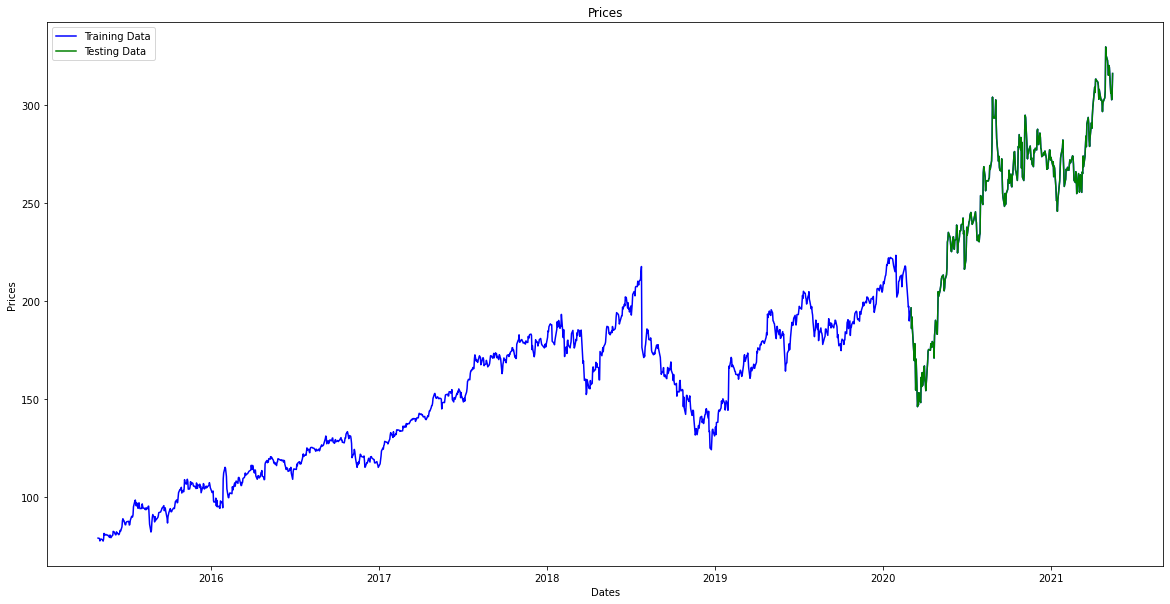

In [9]:
# Plot Showing stock trend
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]
plt.figure(figsize=(20,10))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(data['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Autocorrelation plot')

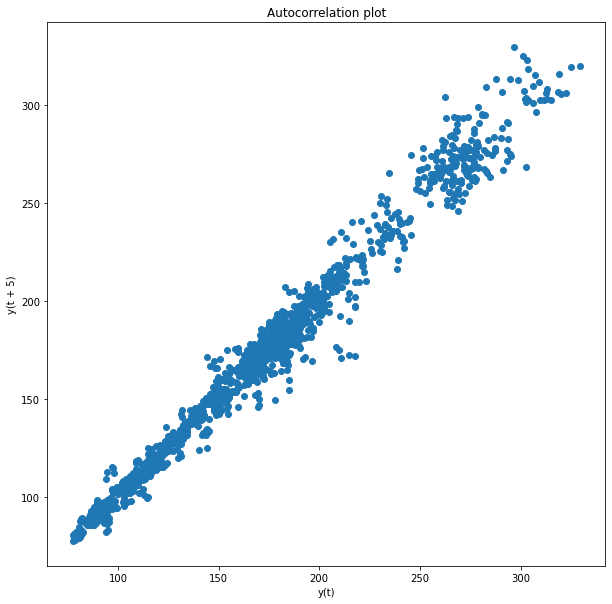

In [10]:
# Plotting autocorrelation
plt.figure(figsize=(10,10))
lag_plot(data['Close'], lag=5)
plt.title('Autocorrelation plot')

In [11]:
#Symmetric mean absolute percentage error used for relative errors
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

#### Building ARIMA model

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

Symmetric mean absolute percentage error: 18.817


#### Evaluating the model

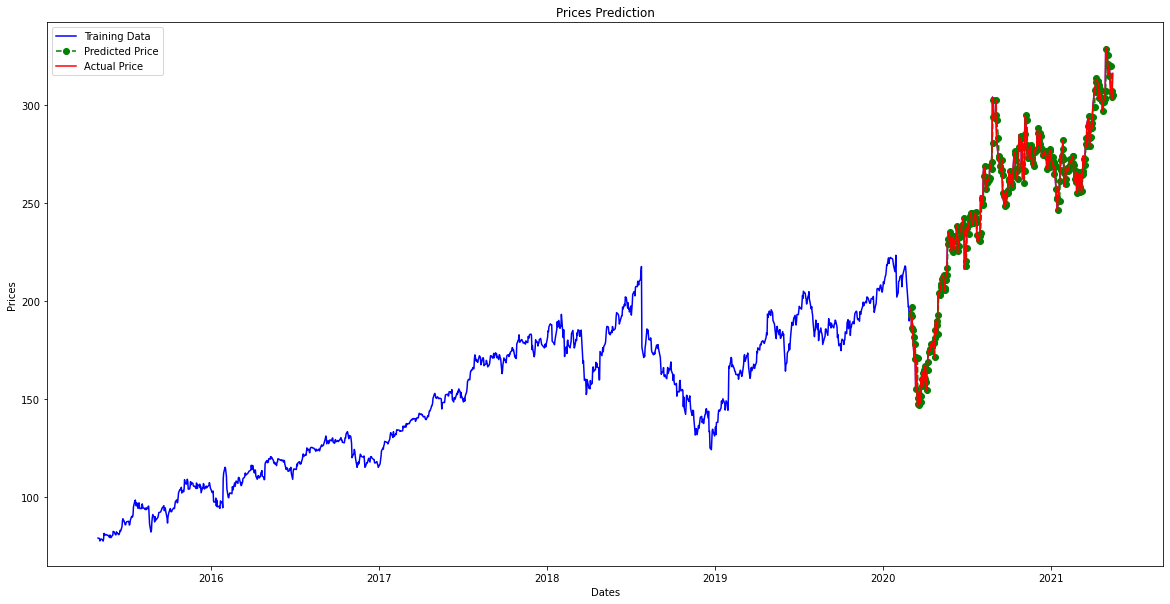

In [13]:
# Plotting predictide price with actual price
plt.figure(figsize=(20,10))
plt.plot(data['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [14]:
# Displaying the predicted values in pandas DataFrame
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
predict.rename(columns={0: "Close"})
predict.head()

,0
Date,
2020-03-02,193.334379
2020-03-03,196.855531
2020-03-04,186.043271
2020-03-05,192.382137
2020-03-06,185.261493


In [15]:
# Displaying the predicted vs actual data for random date
random_actual = data['Close'].loc['4/30/2021']
random_predicted = predict[0].loc['4/30/2021']
print('Actual Price:',random_actual,' | ',' Predicted Price:' , random_predicted)

Actual Price: 325.08  |   Predicted Price: 328.35937071333734


In [20]:
data['Prediction'] = round(predict[0],2)
data['Close'] = round(data['Close'],2)

In [21]:
data[['Close', 'Prediction']].tail()
data = data.dropna()

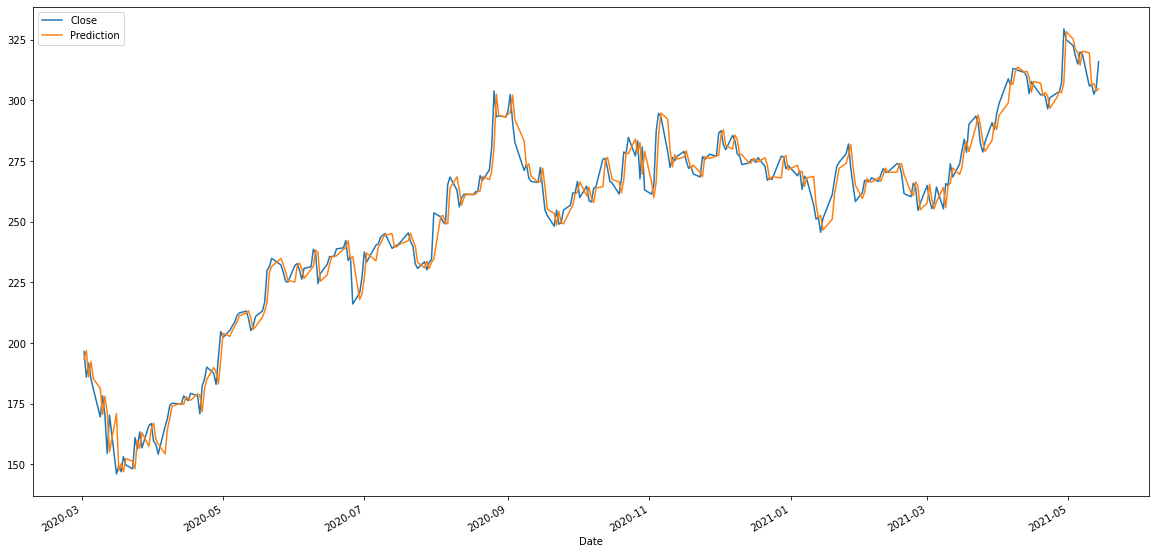

In [22]:
S1 = pd.Series(data['Close'])
S2 = pd.Series(data['Prediction'])
pd.concat([S1,S2],axis=1).plot(figsize=(20,10))
plt.show()

In [23]:
# Calculating the p value
from statsmodels.tsa.stattools import coint
score, pvalue, _ = coint(data['Close'], data['Prediction'])
print('P Value', pvalue)

P Value 1.1908148184850583e-18


In [24]:
# Calculating the correlation between actual and predicted data
data['Close'].corr(data['Prediction'])

0.9879508500481978

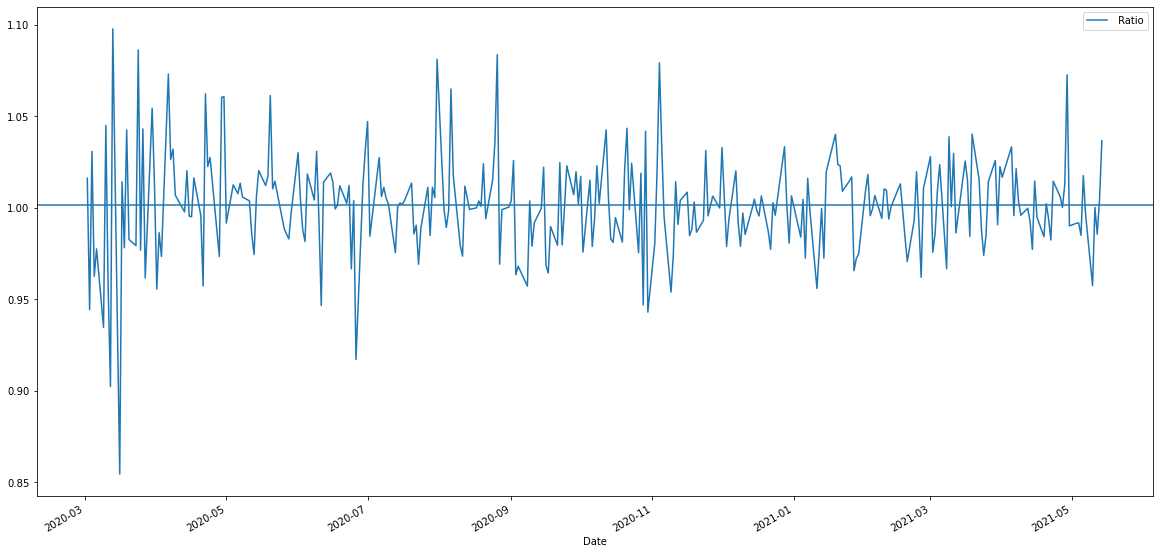

In [25]:
plt.figure(figsize=(20,10))
actual = data['Close']
predicted = data['Prediction']
# score, pvalue, _ = coint(S1, S2)
# print(pvalue)
ratios = actual / predicted
ratios.plot()
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

In [26]:
def zscore(series) :
    return (series - series.mean())/np.std(series)

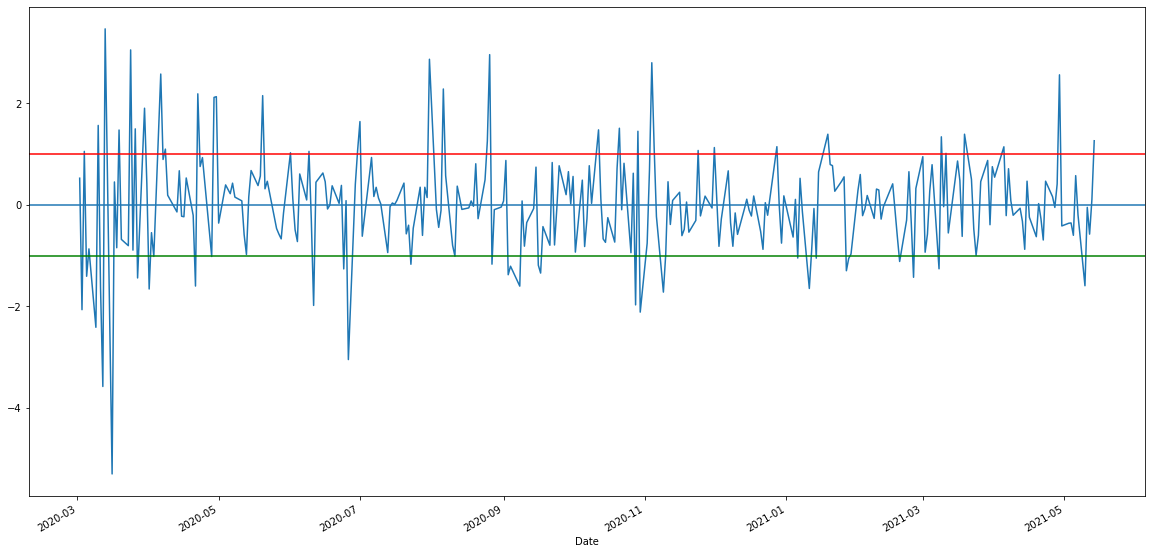

In [27]:
plt.figure(figsize=(20,10))
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

In [28]:
# Calculating the z score
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Close'] = data['Close']
testZScores['Prediction'] = data['Prediction']

In [29]:
testZScores.head()

,Z Score,Close,Prediction
Date,,,
2020-03-02,0.524225,196.44,193.33
2020-03-03,-2.068257,185.89,196.86
2020-03-04,1.053455,191.76,186.04
2020-03-05,-1.409518,185.17,192.38
2020-03-06,-0.869118,181.09,185.26


In [30]:
# Considering the z threshodl which can be experimented
zthreshold = 0.2

In [31]:
testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                'Buy ',
                                 np.where(testZScores['Z Score']>=zthreshold, 
                                          'Sell',
                                          np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                   'Hold',
                                                   'Invalid')))

In [32]:
actions = testZScores[['Close', 'Action']]
actions.head(10)

,Close,Action
Date,,
2020-03-02,196.44,Sell
2020-03-03,185.89,Buy
2020-03-04,191.76,Sell
2020-03-05,185.17,Buy
2020-03-06,181.09,Buy
2020-03-09,169.50,Buy
2020-03-10,178.19,Sell
2020-03-11,170.24,Buy
2020-03-12,154.47,Buy
